# Information Retrieval Project - MobileNet model implementation
## COVID-19 Search Engine (P12)

Content-based image retrieval (CBIR) is a computer vision technique which addresses the problem of searching for digital images in large databases. A content-based approach exploits the contents of an image, such as colors, shapes and textures, differing from its concept-based counterpart, which instead focuses on keywords and tags associated with the image itself.

Image retrieval has gained more and more relevance in the medical field, due to the accumulation of extensive collections of scans in hospitals. These images are stored in DICOM format, which must be manually annotated and may require considerable time to process by physicians. The goal of this project is trying to address this problem by considering different approaches for building a content-based medical image retrieval system and comparing their results based on classification metrics and computational time.

# Installation of Requirements

This part of the code installs necessary dependencies specified in the `requirements.txt` file.
Utilizes the `!pip install -r requirements.txt` command to install packages listed in the `requirements.txt` file. This ensures that all required dependencies are installed before proceeding with execution.


In [ ]:
!pip install -r requirements.txt

# Importing Required Libraries

This part of the code imports necessary libraries.

In [1]:
# Import
import os
import time
import glob
import keras
import kaggle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from keras.models import Model
from keras.layers import Flatten
from keras.utils import load_img, img_to_array
from keras.applications.mobilenet import MobileNet, preprocess_input

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


# Definition of constants

This part of the code defines useful constants.

In [2]:
# PATHS
DATASET_PATH = "archives"  # Path to the dataset
DATASET_ID = "plameneduardo/sarscov2-ctscan-dataset"  # ID for Kaggle API. Format: dataset_owner_name/dataset_name
COVID_PATH = os.path.join(DATASET_PATH, "COVID")  # Path to data labeled as COVID
NON_COVID_PATH = os.path.join(DATASET_PATH, "non-COVID")  # Path to data labeled as non-COVID
DATA_PATH = "data"  # Path to the data folder 
PLOT_PATH = "plot"  # Path to the plot folder
MOBILENET_TRAIN_JSON = os.path.join(DATA_PATH, f"mobilenet_train_data.json")  # Path to Training indexed data
MOBILENET_TEST_JSON = os.path.join(DATA_PATH, f"mobilenet_test_data.json")  # Path to Test indexed data


# DATA RELATED
CLASSES = ["COVID", "non-COVID"]
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# SIMILARITY RELATED
COSINE = "Cosine" 
TOP_N = 100  # Number of images retrieved
K_VALUES = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # K ranking values 
PLOT_K = 20  # Value k chosen for simple plot representation
RELEVANT_PICK = 5  # Number of RELEVANT images picked by relevance feedback process
IRRELEVANT_PICK = 3  # Number of IRRELEVANT images picked by relevance feedback process

# ROCCHIO's ALGORITHM WEIGHTS
ALPHA = 1
BETA = 0.75
GAMMA = 0.15


# Defining the Workspace

Download the dataset and define usefull directory to store data and plot.

## Function: `download_dataset_from_kaggle`

### Description:
This function downloads the specified dataset from the Kaggle website using the Kaggle module. It checks if the dataset already exists in the specified location and downloads it if not present. Additionally, it unzips the downloaded dataset.

### Workspace Operations:
1. **Create Data Folder**: A data folder is created at the location specified by `DATA_PATH`, if it does not already exist.
2. **Create Plot Folder**: A plot folder is created at the location specified by `PLOT_PATH`, if it does not already exist.


In [3]:
# Download dataset from Kaggle website
def download_dataset_from_kaggle(dataset_id: str, dataset_path: str) -> None:
    """
    Download the sarscov2-ctscan-dataset using Kaggle module

    :param dataset_id: identify the dataset to download.
        Format: dataset_owner_name/dataset_name
    :param dataset_path: location to save the dataset

    :return: None
    """
    # Download the dataset if not exist in the workplace
    if not os.path.exists(path=dataset_path):
        
        print("\n> Download the dataset from Kaggle...")
        # Download dataset and unzip it
        kaggle.api.dataset_download_files(dataset=dataset_id, path=dataset_path, quiet=False, unzip=True)
    else:
        print("\n> Dataset already downloaded.")


## ************************************ DEFINING THE WORKSPACE ********************************** ##      


# Execute the download operation
download_dataset_from_kaggle(dataset_id=DATASET_ID, dataset_path=DATASET_PATH)

# Create data folder
os.makedirs(DATA_PATH, exist_ok=True)

# Create plot folder
os.makedirs(PLOT_PATH, exist_ok=True)



> Dataset already downloaded.


# Dataset Preprocessing Summary

dataset management and pre-processing tasks.

## Function: `count_files`

### Description:
This function counts the number of files with specified extensions in the specified directory. It iterates over the directory and checks each file's extension against the provided list of extensions.

---

## Function: `print_file_counts`

### Description:
A helper function that prints information about the number of files inside the COVID and non-COVID directories.

---

### Function: `corruption_filter`

### Description:
This function checks the dataset for corrupted files and deletes them if requested. It finds all image files in the dataset, loops through each file, and attempts to open it using `PIL.Image.open()`. If an `UnidentifiedImageError` occurs, the file is considered corrupted.

---

## Function: `checking_dataset`

### Description:
This function performs a preliminary check on the dataset by calling `corruption_filter` to analyze and control the dataset for corrupted files.

---


In [ ]:
# Count the number of files
def count_files(directory_path: str) -> int:
    """
    Count the number of files in the given directory, regardless of the file extension.
    
    :param directory_path: The path to the directory for which file count is required.
    :return: The number of files in the directory.
    """
    # Return counter 
    return sum(1 for entry in os.scandir(directory_path) if entry.is_file())


# Just a helper function
def print_file_counts() -> None:
    """
    A helper function that print information about the number of files inside the directory.
    
    :return: None
    """
    # Count files in each directory
    count_covid = count_files(directory_path=COVID_PATH)  # Count COVID files
    count_non_covid = count_files(directory_path=NON_COVID_PATH)  # Count non-COVID files
    tot_number_file = count_covid + count_non_covid
    
    # Print the counts
    print(f"- Total Number of files: {tot_number_file}\n"
          f"- Number of files in COVID: {count_covid}\n"
          f"- Number of files in non-COVID: {count_non_covid}\n")
    

# Images verification 
def verify_image(image_path: str) -> bool:
    """
    Verify if an image file is corrupted.
    
    :param image_path: (str) The path to the image file.
    :return: (bool) True if the image is valid, False if it is corrupted.
    """
    try:
        with Image.open(image_path) as img:
            img.verify()
        return True
    except UnidentifiedImageError:
        return False


# Check dataset: filter out possible corrupted files.
def corruption_filter(dataset_path: str) -> None:
    """
    Check for corrupted image files in the dataset and delete them if requested.
    
    :param dataset_path: The path to the dataset.
    """
    # Find all PNG image files in the dataset recursively
    bad_files = [f for f in glob.glob(os.path.join(dataset_path, "**", "*.png"), recursive=True)
                 if not verify_image(f)]
    
    if bad_files:  # If there are corrupted files
        print(f"\n> There are {len(bad_files)} corrupted files: {bad_files}")
        # Prompt user to delete corrupted files
        if input("\n> Do you want to delete these files? [Y/N]: ").upper() == "Y":
            for bad_file in bad_files:
                os.remove(bad_file)  # Delete corrupted file
                print(f"- {bad_file} Corrupted File Deleted Successfully!")
            print("\n> Checking the Number of files after applying the corruption filter:")
            print_file_counts()  # Print file counts after deletion
    else:
        print("> No Corrupted File Found")  # If no corrupted files found

# Pre-Processing Workflow
def checking_dataset(dataset_path: str) -> None:
    """
    Preliminary check on dataset:
        Calling corruption_filter, find_out_duplicate to analyze and control the dataset.
 
    :param dataset_path: The path to the dataset.
    
    :return: None
    """
    print("\n> CHECK THE DATASET")
    print("\n> Checking the Number of file before performing Pre-processing Task...")
    
    # Print count
    print_file_counts()
    
    # Check for corrupted file
    print("> Checking for corrupted files...")
    corruption_filter(dataset_path=dataset_path)
    
    print("\n> Final check to confirm the total file count:")
    print_file_counts()
    
    print("> DATASET CHECK COMPLETE!")


## ************************************ CHECKING THE DATASET ********************************** ##


# Execute Pre-Processing tasks on dataset 
checking_dataset(dataset_path=DATASET_PATH)


# Data Preparation

## Function 1: `build_dataframe`

### Description:
This function constructs a pandas DataFrame from a dataset stored at the specified path. It iterates over the directories in the dataset, appending file paths along with their corresponding class labels to a list.

---

## Function 2: `plot_class_distribution`

### Description:
This function generates a bar graph illustrating the distribution of classes within the provided DataFrame. It calculates the count of each class and plots a bar for each class, with color distinctions.

---

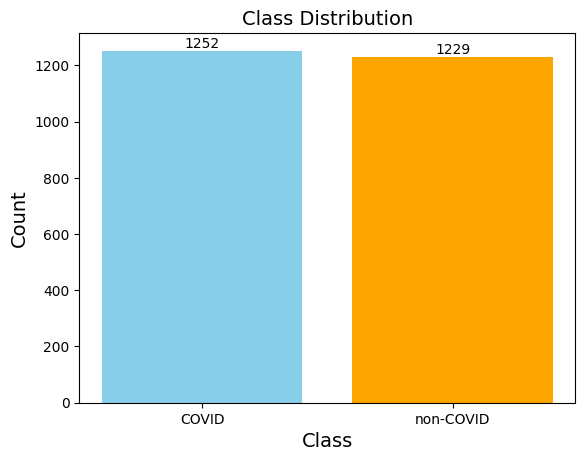

In [5]:
# Define a pandas dataframe
def build_dataframe(dataset_path: str) -> pd.DataFrame:
    """
    Build a dataframe from dataset.
    
    :param dataset_path: Path to the dataset directory.
    
    :return: DataFrame containing file paths and corresponding class labels.
    """
    # Generate a list of tuples containing file paths and their corresponding class labels
    data = [
        (os.path.join(dataset_path, directory_name, file), class_label)
        for class_label, directory_name in enumerate(CLASSES)
        for file in os.listdir(os.path.join(dataset_path, directory_name))
    ]
    # Create a DataFrame from the list of tuples with appropriate column names
    data_df = pd.DataFrame(data, columns=["file_paths", "labels"])
    
    return data_df


# Plot the distribution of classes
def plot_class_distribution(data: pd.DataFrame) -> None:
    """
    Plot bar graph showing the distribution of classes.
    
    :param data: pd.Dataframe contain data.
    
    :return: None.
    """
    class_count = [0, 0]  # binary classes
    colors = ["skyblue", "orange"]  # Assigning colors to classes
        
    # Counting 
    for label in data.iloc[:, 1]:
        class_count[label] += 1
    
    # Plot bar-graph      
    bars = plt.bar(CLASSES, class_count, color=colors)
    plt.xlabel("Class", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.title("Class Distribution", fontsize=14)
    
    # Adding labels on top of the bars
    for bar, count in zip(bars, class_count):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
                 ha="center", va="bottom", fontsize=10)
    
    # Save the plot to path
    plot_path = os.path.join(PLOT_PATH, "class_distribution_plot.jpg") 
    plt.savefig(plot_path, dpi=96)

    # Display the plot
    plt.show()

## ************************************ BUILD THE DATASET DATAFRAME ********************************** ##


# Build the dataframe 
dataset_df = build_dataframe(dataset_path=DATASET_PATH)

# Plot dataset's class distribution
plot_class_distribution(data=dataset_df)

# MobileNet

A class for extracting features from images using the MobileNet model.

## 1. Class Structure
The `MobileNetModel` class encapsulates functionality for feature extraction using the MobileNet model. It includes attributes for the input shape, the model itself, and the output layer.

## 2. Initialization
The `__init__` method initializes the `MobileNetModel` object, loading the MobileNet model with pre-trained weights, setting a custom name for the model, and extracting the output layer.

## 3. Loading Images, preprocess and extract features
The `features_extraction` method preprocesses and loads an image from the specified path, extracts features from the image using the initialized MobileNet model, and normalizes the feature vector.


In [6]:
class MobileNetModel:
    """
    A class for extracting features from images using the MobileNet model.
    
    Attributes:
        input_shape (tuple): The shape of the input images expected by the model.
        model (keras.Model): The MobileNet model with the fully connected layers removed.
        output (keras.layers.Layer): The output layer of the model.
    """
    def __init__(self):
        """
        Initializes the MobileNet object.
        """
        self.input_shape = INPUT_SHAPE  # Input shape
        self.base_model = MobileNet(weights="imagenet", input_shape=self.input_shape, include_top=False)  # Load model with pre-trained weights (ImageNet)
        x = self.base_model.output  # Base model
        x = Flatten()(x)  # Flatten layer: two-dimensional array -> one-dimensional vector 
        self.output = x  # Get output layer of the model
        self.model_name = "MobileNet"  # Custom name for the model
        self.model = Model(self.base_model.input, self.output, name=self.model_name)  
        

    # Load, preprocessing and extract features
    def features_extraction(self, path_to_data: str) -> np.ndarray:
        """
        Preprocesses and loads an image from the specified path.

        :param path_to_data: The path to the image file.
 
        :return numpy.ndarray: The preprocessed image as a numpy array.
        """
        # Load the image and resize it to match the input shape of the model
        x = load_img(path=path_to_data, target_size=(self.input_shape[0], self.input_shape[1]))
        
        # Convert image to NumPy array
        x = img_to_array(img=x) 
        
        # Add an extra dimension at the beginning for batch
        x = np.expand_dims(a=x, axis=0) 
        
        # Preprocess the image according to the model's requirements
        x = preprocess_input(x=x)
        
        # Get the predictions from the model for the input image
        feature = self.model.predict(x=x)[0]
        
        # Normalize the feature vector
        feature = feature / np.linalg.norm(x=feature)
        
        return feature
    

In [7]:
# Features extraction and extraction time 
def extract_features(model: MobileNetModel, dataframe: pd.DataFrame) -> tuple[list[np.ndarray], float]:
    """
    Extract features from all images in the dataframe and the time taken for the total extraction.
    
    :param dataframe: DataFrame containing image file paths and labels.
    :param model: Instance of VGG16Model for feature extraction.
    :return: List of extracted features and total extraction time.
    """
    start_time = time.time()
    collect_features = []
    
    for _, row in dataframe.iterrows():
        file_path = row["file_paths"]
        print(f"Processing file: {file_path}")
        feature = model.features_extraction(path_to_data=file_path)
        collect_features.append(feature)
    
    return collect_features, time.time() - start_time


## ************************************ MOBILENET - FEATURES EXTRACTION ********************************** ##


# Create an instance of MobileNet class
mobilenet_model = MobileNetModel()
# Plot the model summary
mobilenet_model.model.summary()

# Check if the files exist
if not (os.path.exists(MOBILENET_TRAIN_JSON) and os.path.exists(MOBILENET_TEST_JSON)):
    # Compute features and time
    features, total_time = extract_features(model=mobilenet_model, dataframe=dataset_df)
    dataset_df["features"] = features
    # Print info. about total extraction time
    print(f"\n> Total time taken: {total_time:.2f} seconds - {total_time / 60:.2f} minutes")
    
    # Splitting dataset into Training and Test and save them as JSON
    train_df, test_df = train_test_split(dataset_df, test_size=0.2, shuffle=True, random_state=4)
    train_df.to_json(MOBILENET_TRAIN_JSON, orient="records") 
    test_df.to_json(MOBILENET_TEST_JSON, orient="records")

    # Create a DataFrame to collect model name and elapsed time and save it as a csv file
    pd.DataFrame({
        "model_name": [mobilenet_model.model_name], 
        "time_seconds": [total_time], 
        "time_minutes": [total_time / 60]
    }).to_csv(os.path.join(DATA_PATH, f"{mobilenet_model.model_name}_extraction_time.csv"), index=False, float_format="%.2f")
else:  # if the files already exist
    print("\n> The features have already been extracted. Proceed with the next steps.\n")
    

Model: "MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)


> The features have already been extracted. Proceed with the next steps.



# Find Similar Image to Query

## Function 1: `find_top_n_similar_images`

### Description:
This function identifies the top N similar images to a query image based on cosine similarity. It calculates the cosine similarity between the features of the query image and all other images in the dataset, sorts the distances, and returns the indices and distances of the top similar images.

---

## Function 2: `plot_similar_images`

### Description:
This function plots the query image along with similar images, their distances, and associated classes. It organizes the images in a grid structure with legend, query image, and similar images. It distinguishes between same and different classes using different colors and saves the plot as a .png file.

---

## Function 3: `choose_query_file`

### Description:
This function prompts the user to choose a query image file from the test dataset. It constructs a message with options for file selection and validates user input to ensure a valid index is provided.

---


In [12]:
# Compare features based on cosine distance
def find_top_n_similar_images(features_of_query: np.ndarray, all_features: np.ndarray, top_n=TOP_N) -> tuple[np.ndarray, np.ndarray]:
    """
    Find top_n similar images to the query image based on a given cosine similarity.
 
    :param features_of_query: Features of the query image.
    :param all_features: Features of all images in the dataset.
    :param top_n: Number of top similar images to consider. 
        Default is 20.
        
    :return: closest_indices:  Index of the closest similar images to the query image;
             closest_distances: Distances between the closest similar images to the query image.
    """
    # Calculate distances between the query image features and all other images
    similarity_measure = cosine_similarity(X=features_of_query.reshape(1, -1), Y=all_features)
    
    # Sort distances and get the indices of the closest images
    closest_indices = np.argsort(similarity_measure[0])[::-1][:top_n]
    closest_similarities = similarity_measure[0][closest_indices]
    
    return closest_indices, closest_similarities


# Plot similar images based on cosine distance method
def plot_similar_images(path_to_query: str, query_label: int, similar_image_paths: list[str], 
                        similar_image_labels: np.ndarray[int], distance_measures: np.ndarray[float], k: int=PLOT_K, is_relevance: bool=False) -> None:
    """
    Plot the query image along with similar images, their distances, and associated classes.

    :param path_to_query: File path of the query image.
    :param query_label: Class label of the query image.
    :param similar_image_paths: List of file paths of retrieved similar images.
    :param similar_image_labels: List of true class labels corresponding to retrieved similar images.
    :param distance_measures: List of distance values corresponding to retrieved similar images.
    :param k: number of images retrieved among the TOP_N similar images.
    :param is_relevance: Boolean value indicating whether is used Relevance Feedback procedure.
    
    :return: None.
    """
    # Plot only the first k images
    similar_image_paths = similar_image_paths[:k]
    similar_image_labels = similar_image_labels[:k]
    distance_measures = distance_measures[:k]
    
    num_similar_images = len(similar_image_paths)  # Number of similar images retrieved
    num_rows = int(np.ceil(num_similar_images / 5))  # Organize in a grid structure with 5 images per row

    # Load and display the query image separately
    plt.figure(figsize=(20, (num_rows + 1) * 4))
    
    # Define legend colors
    red_patch = patches.Patch(color="red", label="Different Classes")
    green_patch = patches.Patch(color="green", label="Same Classes")
    plt.legend(handles=[red_patch, green_patch], loc="upper right", fontsize=12)
    plt.axis("off")
    
    # Add legend for distance metric and its range
    plt.subplot(num_rows + 1, 5, 1)
    plt.axis("off")
    
    # Define legend text
    legend_text = ("LEGEND\n"
                   " - Similarity: Cosine\n"
                   " - Range: \n"
                   "   (-1) = Perfectly dissimilar\n"
                   "   (0) = No similarity\n"
                   "   (1) = Perfectly similar")
    
    # Add legend text
    plt.text(x=0, y=0.5, s=legend_text, fontsize=14, ha="left", weight="bold", bbox=dict(facecolor="white", alpha=0.5))
    
    # Centered position for the query image
    plt.subplot(num_rows + 1, 5, 3) 
    # Query image path
    query_image_path = mpimg.imread(fname=path_to_query)
    # Display query image
    plt.imshow(query_image_path)
    
    # Label title for query image
    if query_label == 0:
        file_base_name = os.path.basename(path_to_query)
        plt.title(f"Query Image:{file_base_name}\nClass: COVID", fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
    else:
        file_base_name = os.path.basename(path_to_query)
        plt.title(f"Query Image:{file_base_name}\nClass: NON COVID", fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
    plt.axis("off")

    # Plot similar images and their distances in a grid
    for figure_number, (path, similar_class, distance_parameter) in enumerate(zip(similar_image_paths, similar_image_labels, distance_measures), 1):
        
        # Start plotting from the 2nd row
        plt.subplot(num_rows + 1, 5, figure_number + 5)
        # Similar image path
        similar_image_path = mpimg.imread(fname=path)
        # Display similar images retrieved
        plt.imshow(X=similar_image_path)
        
        # Use different colors for a better result presentation
        if similar_class == query_label:
            title_color = "green"
        else:
            title_color = "red"
        
        if similar_class == 0:
            file_base_name = os.path.basename(path)
            plt.title(f"Image:{file_base_name}\nClass: COVID\n Score: {distance_parameter:.3f}", 
                      color=title_color, fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
        else:
            file_base_name = os.path.basename(path)
            plt.title(f"Image:{file_base_name}\nClass: NON COVID\n Score: {distance_parameter:.3f}", 
                      color=title_color, fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
        plt.axis("off")
        
    plt.tight_layout()
    
    if not is_relevance:
        # Save the plot to path
        plot_path = os.path.join(PLOT_PATH, f"{mobilenet_model.model_name}_{os.path.basename(path_to_query).split(".")[0]}.png") 
        plt.savefig(plot_path, dpi=96)
    else:
        # Save the plot to path
        plot_path = os.path.join(PLOT_PATH, f"{mobilenet_model.model_name}_feedback_{os.path.basename(path_to_query).split(".")[0]}.png") 
        plt.savefig(plot_path, dpi=96)
    
    # Display plot
    plt.show()
    

# Choose which of the images to analyze and how
def choose_query_file(query_dataset: pd.DataFrame) -> tuple[str, int, np.array]:
    """
    Prompts the user to choose a query image file from the test dataset.

    :param query_dataset: DataFrame containing image file paths and labels.

    :returns: query_file_path: query file path.
              query_labels: query corresponding class label.
    """
    # Construct the prompt message for file selection
    file_names = [os.path.basename(path) for path in query_dataset["file_paths"]]
    file_prompt_message = (f"Enter the index of the file you want to select.\n"
                           f"Options:\n\n[index - file]\n")
    for i, file_name in enumerate(file_names):
        file_prompt_message += f"{i}\t-\t{file_name}\n"

    while True:
        file_choice = input(file_prompt_message)
        if file_choice.strip() == "":
            print("No input provided. Please enter a valid index!")
            continue

        try:
            file_choice = int(file_choice)
            if file_choice < 0 or file_choice >= len(query_dataset):
                print("Invalid index. Please choose a valid index!")
                continue
            else:
                break
        except ValueError:
            print("Invalid input. Please enter a valid index!")

    query_file_path = query_dataset.iloc[file_choice]["file_paths"]
    query_label = query_dataset.iloc[file_choice]["labels"]
    query_feature = query_dataset.iloc[file_choice]["features"]

    return query_file_path, query_label, np.array(query_feature)



> Query image: Covid (1230).png
> Query label: 0


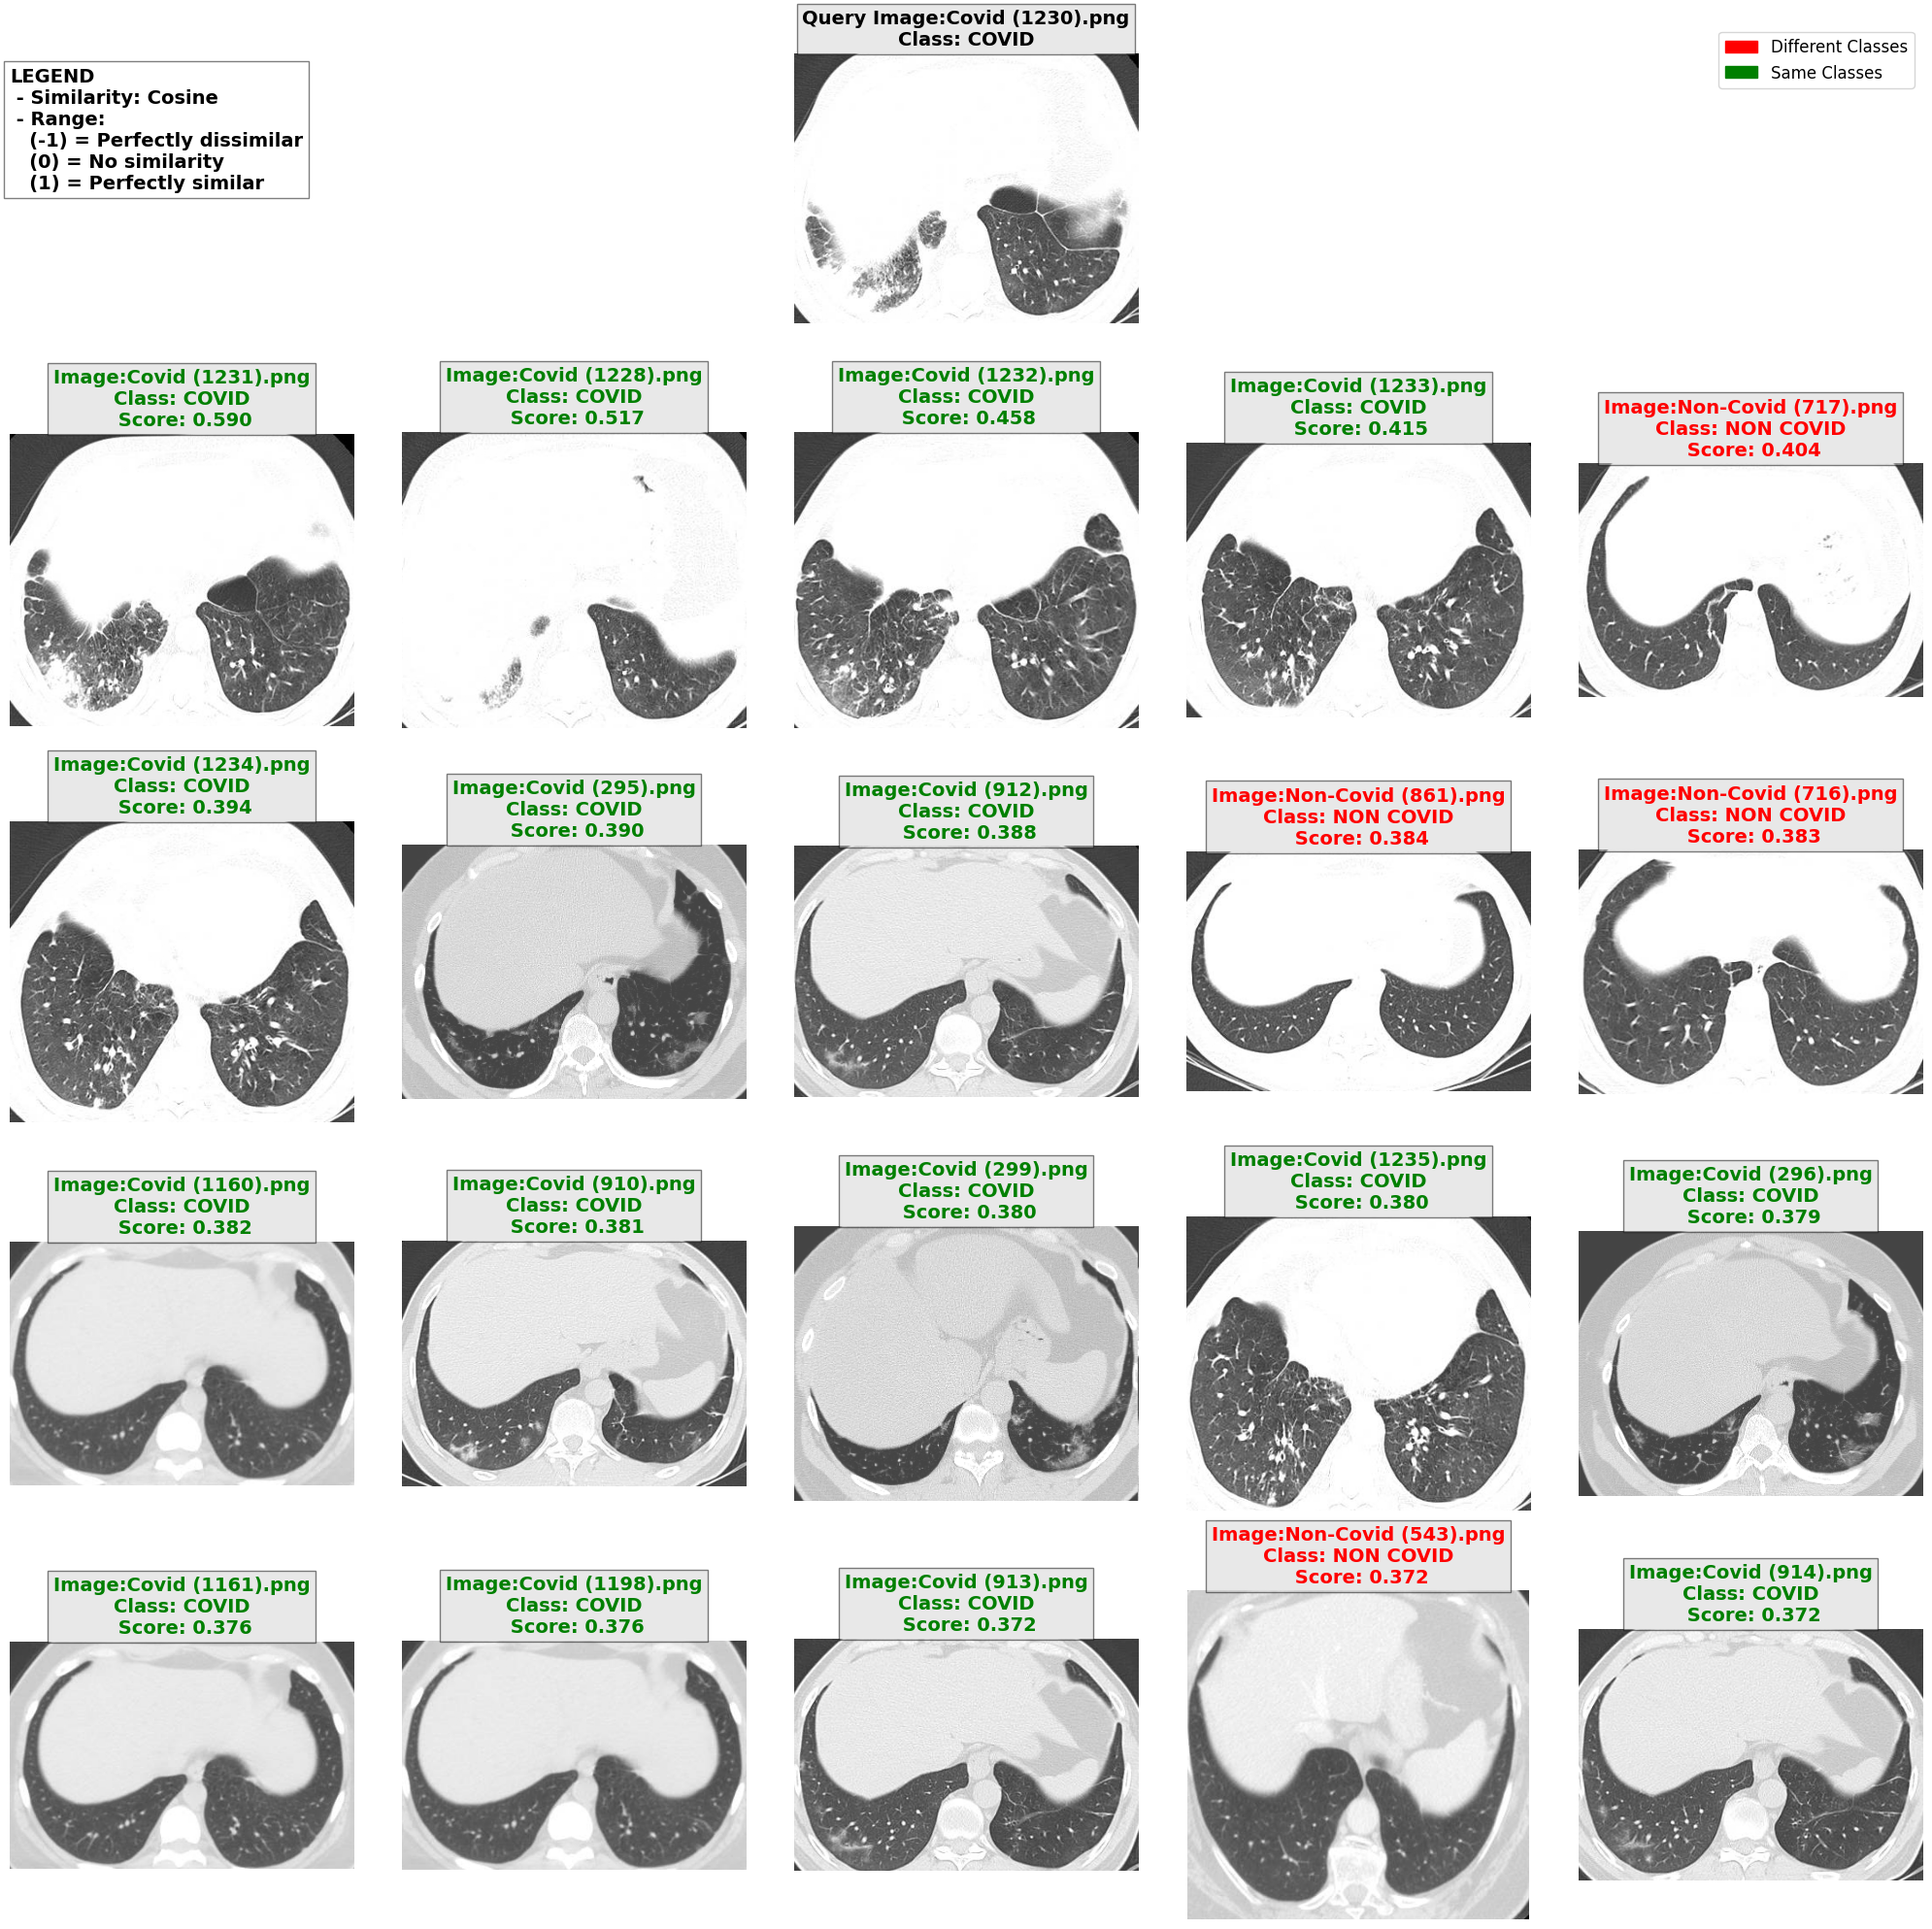

In [32]:
## ************************************ MOBILENET - FROM QUERY FIND SIMILAR ********************************** ##


# Load training and test datasets
train_dataset = pd.read_json(path_or_buf=MOBILENET_TRAIN_JSON)
test_dataset = pd.read_json(path_or_buf=MOBILENET_TEST_JSON)

# Select 5 random samples from each class in the test dataset
selected_class_0 = test_dataset[test_dataset["labels"] == 0].sample(n=5, random_state=19)
selected_class_1 = test_dataset[test_dataset["labels"] == 1].sample(n=5, random_state=19)

# Concatenate the samples to create a demo subset
sample_test_subset = pd.concat([selected_class_0, selected_class_1])

# Choose a file from the test dataset subset
chosen_file_path, chosen_label, chosen_features = choose_query_file(query_dataset=sample_test_subset)
# Print info. about chosen query
print(f"\n> Query image: {os.path.basename(p=chosen_file_path)}"
      f"\n> Query label: {chosen_label}")

# Compute cosine distances and find similar images
train_features = np.array(train_dataset["features"].to_list()) 
similar_indices, similar_distances = find_top_n_similar_images(features_of_query=chosen_features, all_features=train_features)

# Retrieve paths and labels of the similar images
similar_images = train_dataset.iloc[similar_indices]["file_paths"].tolist()
similar_labels = train_dataset.iloc[similar_indices]["labels"].to_numpy()

# Given query -> Plot similar images with class labels and info.
plot_similar_images(path_to_query=chosen_file_path,
                    query_label=chosen_label,
                    similar_image_paths=similar_images,
                    similar_image_labels=similar_labels,
                    distance_measures=similar_distances)


# Evaluation on the entire test set

## Function: `get_average_model_performance`

### Description:
This function evaluates the test dataset by computing precision, recall, and F1-score for each sample. It iterates through each feature in the test dataset, computes cosine similarity to find similar images, evaluates similarity, and computes precision, recall, and F1-score. Finally, it computes the average precision, recall, and F1-score for the entire test dataset.


In [33]:
# Evaluation of the model performance
def compute_evaluation_metrics(query_img_label: int, image_labels_retrieved: np.ndarray[int], k:int) -> tuple[float, float, float, float]:
    """
    Evaluate the similarity between the query image and the Top N most similar images.

    :param query_img_label: Label of the query image.
    :param_ image_labels_retrieved: Labels of the Top-N most similar images retrieved.
    :param k: The number of top items to consider.

    :return: precision, recall, F1-score.
    """
    # Count of the Relevant K items
    k_relevant_retrieved = np.sum(image_labels_retrieved[:k] == query_img_label)
    # Compute Precision score
    precision_score = k_relevant_retrieved / k
    
    # Count of the All Relevant items in the Top N images retrieved
    total_relevant_items = np.sum(image_labels_retrieved == query_img_label)
    # Compute Recall score 
    recall_score = k_relevant_retrieved / total_relevant_items if total_relevant_items != 0 else 0.0
    
    # Compute F1-score
    if precision_score + recall_score > 0.0:
        f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
    else:
        f1_score = 0.0
    
    # Relevance scores for DCG (1 for relevant, 0 for non-relevant)
    relevance_scores = np.array(image_labels_retrieved == query_img_label)[:k]
    # Compute DCG
    dcg = np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2))) if relevance_scores.size != 0 else 0.0 

    return precision_score, recall_score, f1_score, dcg


In [34]:
## ************************************ MOBILENET - SINGLE CASE PERFORMANCE EVALUATION ********************************** ##


# Compute precision, recall and f1-score
precision_score_value, recall_score_value, f1_score_value, dcg_score_value = compute_evaluation_metrics(
    query_img_label=chosen_label, 
    image_labels_retrieved=similar_labels,
    k=20
)
# Print info. about chosen query
print(f"\n> Query: {os.path.splitext(os.path.basename(chosen_file_path))[0]}"
      f"\n> Label: {chosen_label}")

# Print Evaluation scores
print(f"\n> MOBILENET SINGLE CASE PERFORMANCE EVALUATION:")
print(f"-- Precision score: {precision_score_value:.3f}")
print(f"-- Recall score: {recall_score_value:.3f}")
print(f"-- F1-score: {f1_score_value:.3f}")
print(f"-- DCG: {dcg_score_value:.3f}")



> Query: Covid (1230)
> Label: 0

> MOBILENET SINGLE CASE PERFORMANCE EVALUATION:
-- Precision score: 0.800
-- Recall score: 0.200
-- F1-score: 0.320
-- DCG: 5.832


# Evaluation on the entire test set

## Function: `get_average_model_performance`

### Description:
This function evaluates the test dataset by computing precision, recall, and F1-score for each sample. It iterates through each feature in the test dataset, computes cosine similarity to find similar images, evaluates similarity, and computes precision, recall, and F1-score. Finally, it computes the average precision, recall, and F1-score for the entire test dataset.


In [ ]:
# Evaluation performed on all the element of the test set
def get_average_model_performance(query_dataset: pd.DataFrame, training_dataset: pd.DataFrame, all_retrieved_features: np.ndarray) -> pd.DataFrame:
    """
    Evaluate the test dataset by computing precision, recall, and F1-score and output the average values.

    :param query_dataset: DataFrame containing the test dataset.
    :param training_dataset: DataFrame containing the training dataset.
    :param all_retrieved_features: Retrieved similar features.

    :return: average precision, average recall, and  average f1-score.
    """
    # Dictionary to collect data
    metrics = {k: {"precision": [], "recall": [], "f1": [], "dcg": []} for k in K_VALUES}
    
    print("\n> Computing evaluation metrics for each test sample...\n")
    # Iterate through each feature in the test dataset
    for query_file_path, query_label, query_feature in zip(query_dataset["file_paths"], query_dataset["labels"], query_dataset["features"]):
        # Print info. 
        print(f"-- Processing: {query_file_path}")
        # Compute cosine similarity and find similar images
        similar_index, similar_distance = find_top_n_similar_images(features_of_query=np.array(query_feature), all_features=all_retrieved_features)
        # Extract labels of similar images
        similar_label = training_dataset.iloc[similar_index]["labels"].to_numpy()
        
        # Loop through K
        for k in K_VALUES:
            # Compute precision, recall, and F1-score
            precision, recall, f1, dcg = compute_evaluation_metrics(query_img_label=query_label, image_labels_retrieved=similar_label, k=k)
            # Append scores to Dictionary
            metrics[k]["precision"].append(precision)
            metrics[k]["recall"].append(recall)
            metrics[k]["f1"].append(f1)
            metrics[k]["dcg"].append(dcg)   
    print("\n> Process completed!")

    # Compute metrics average and build a dataframe
    avg_metrics = {k: {"avg_precision": np.mean(metrics[k]["precision"]),
                       "avg_recall": np.mean(metrics[k]["recall"]),
                       "avg_f1": np.mean(metrics[k]["f1"]),
                       "avg_dcg": np.mean(metrics[k]["dcg"])}
                   for k in K_VALUES}
    df_avg_metrics = pd.DataFrame.from_dict(avg_metrics, orient="index")
    df_avg_metrics.index.name = "K"
    
    # Save the Dataframe as CSV
    metrics_path = os.path.join(DATA_PATH, f"{mobilenet_model.model_name}_evaluation.csv")
    df_avg_metrics.to_csv(path_or_buf=metrics_path, float_format="%.4f")

    return df_avg_metrics
    
    
## ************************************ MOBILENET - COMPUTE MODEL PERFORMANCE EVALUATION ********************************** ##


# Compute Average Classification metrics values
average_metrics  = get_average_model_performance(
    query_dataset=test_dataset, 
    training_dataset=train_dataset, 
    all_retrieved_features=train_features
)


In [36]:
# Print average performance
print(f"\n> MOBILENET AVERAGE PERFORMANCE:")
print(average_metrics.to_string())



> MOBILENET AVERAGE PERFORMANCE:
     avg_precision  avg_recall    avg_f1    avg_dcg
K                                                  
5         0.948089    0.077789  0.142019   2.824132
10        0.897787    0.144193  0.243980   4.178297
20        0.825956    0.257052  0.383418   6.065531
30        0.784842    0.360233  0.482305   7.555976
40        0.756288    0.458255  0.557439   8.850281
50        0.733682    0.551665  0.615358  10.012372
60        0.715392    0.643297  0.662084  11.085032
70        0.701466    0.734494  0.701680  12.105717
80        0.689462    0.823384  0.734372  13.073648
90        0.678270    0.910645  0.761205  13.988871
100       0.670584    1.000000  0.786549  14.901271


# Relevance feedback

Implement Relevance feedback

## Function 1: `get_relevant_images_features`

### Description:
This function retrieves the features of similar images with the same label as the chosen file based on the provided indices. It filters the indices to include only those with the same label as the chosen file, retrieves the features, file paths, and labels of similar images, and returns them.

---

## Function 2: `get_irrelevant_images_features`

### Description:
This function retrieves the features of images that are not similar to the query image based on the provided indices. It filters the indices to include only those with a different label from the chosen file, retrieves the features, file paths, and labels of such images, and returns them.

---

## Function 3: `relevance_feedback`

### Description:
This function refines the search based on relevance feedback using Rocchio's algorithm. It adjusts the query features based on the retrieved relevant and irrelevant features using the specified weights (ALPHA, BETA, and GAMMA).

---

In [20]:
# Get features of images that are similar respect to query
def get_relevant_images_features(closest_indices_to_query: np.array, all_features: np.array(float), 
                                 training_dataset: pd.DataFrame, query_chosen_label: int, quantity=RELEVANT_PICK) -> tuple[np.ndarray, list[str], np.ndarray[int]] or tuple[None, None, None]:
    """
    Get the features of similar images with the same label as the chosen file based on the indices provided.

    :param closest_indices_to_query: Indices of the similar images.
    :param all_features: Features of all images in the dataset.
    :param training_dataset: Training DataFrame containing image file paths and labels.
    :param query_chosen_label: Label of the chosen file.
    :param quantity: Define how many "images" get for the process.
        
    :return: similar_images_features: Features of similar images with the same label as the chosen file.
    """
    # Filter the indices to include only those with the same label as the chosen file
    indices_with_same_label = [idx for idx in closest_indices_to_query if training_dataset.iloc[idx]["labels"] == query_chosen_label]
    
    if not indices_with_same_label:
        return None, None, None
    
    number_of_indexes = indices_with_same_label[:quantity]
    
    # Get features, file paths, and labels of similar images with the same label
    relevant_images_features = all_features[number_of_indexes]
    relevant_images_paths = [os.path.basename(path) for path in training_dataset.iloc[number_of_indexes]["file_paths"]]
    relevant_images_labels = training_dataset.iloc[number_of_indexes]["labels"].tolist()
    
    return relevant_images_features, relevant_images_paths, relevant_images_labels


# Get features of images that are not similar respect to query
def get_irrelevant_images_features(closest_indices_to_query: np.array, all_features: np.array(float), 
                                   training_dataset: pd.DataFrame, query_chosen_label: int, quantity=IRRELEVANT_PICK) -> tuple[np.ndarray, list[str], np.ndarray[int]] or tuple[None, None, None]:
    """
    Get the features of irrelevant (not similar) images with the same label as the chosen file based on the indices provided.

    :param closest_indices_to_query: Indices of the retrieved images.
    :param all_features: Features of all images in the dataset.
    :param training_dataset: Training DataFrame containing image file paths and labels.
    :param query_chosen_label: Label of the chosen file.
    :param quantity: Define how many images should be considered.
        
    :return: irrelevant_images_features: Features of similar images with the same label as the chosen file; 
    irrelevant_images_paths: Paths of the images considered; irrelevant_images_labels: Labels of the images considered.
    """
    # Filter the indices to include only those with the different label as the chosen file
    indices_with_same_label = [idx for idx in closest_indices_to_query if training_dataset.iloc[idx]["labels"] != query_chosen_label]
    
    if not indices_with_same_label:
        return None, None, None
    
    number_of_indexes = indices_with_same_label[:quantity]
    irrelevant_images_features = all_features[number_of_indexes]
    irrelevant_images_paths = [os.path.basename(path) for path in training_dataset.iloc[number_of_indexes]["file_paths"]]
    irrelevant_images_labels = training_dataset.iloc[number_of_indexes]["labels"].tolist()
    
    # Get features, file paths, and labels of similar images with the same label
    return irrelevant_images_features, irrelevant_images_paths, irrelevant_images_labels
    

# Relevance Feedback improvements
def relevance_feedback(query_features: np.array(float), relevant_features_retrieved: np.array(float), irrelevant_features_retrieved: np.array(float)) -> np.array(float):
    """
    Refine the search based on relevance feedback using Rocchio's algorithm.

    :param query_features: Features of the query image.
    :param relevant_features_retrieved: Features of relevant images.
    :param irrelevant_features_retrieved: Features of irrelevant images.

    :return: updated_query_features: new updated features.
    """
    # Check if there are no relevant or irrelevant features retrieved
    if relevant_features_retrieved is None or irrelevant_features_retrieved is None:
        return np.array(query_features)

    # Compute the centroid of the relevant features
    relevant_centroid = np.mean(relevant_features_retrieved, axis=0)
    
    # Compute the centroid of the irrelevant features
    irrelevant_centroid = np.mean(irrelevant_features_retrieved, axis=0)

    # Adjust the query features using Rocchio's algorithm
    updated_query_features = ALPHA * query_features + BETA * relevant_centroid - GAMMA * irrelevant_centroid
    
    return np.array(updated_query_features)



> Query image: Covid (1230).png
> Query label: 0

> Relevant images: ['Covid (1231).png', 'Covid (1228).png', 'Covid (1232).png', 'Covid (1233).png', 'Covid (1234).png'] - Labels: [0, 0, 0, 0, 0]

> Irrelevant images: ['Non-Covid (717).png', 'Non-Covid (861).png', 'Non-Covid (716).png'] - Labels: [1, 1, 1]


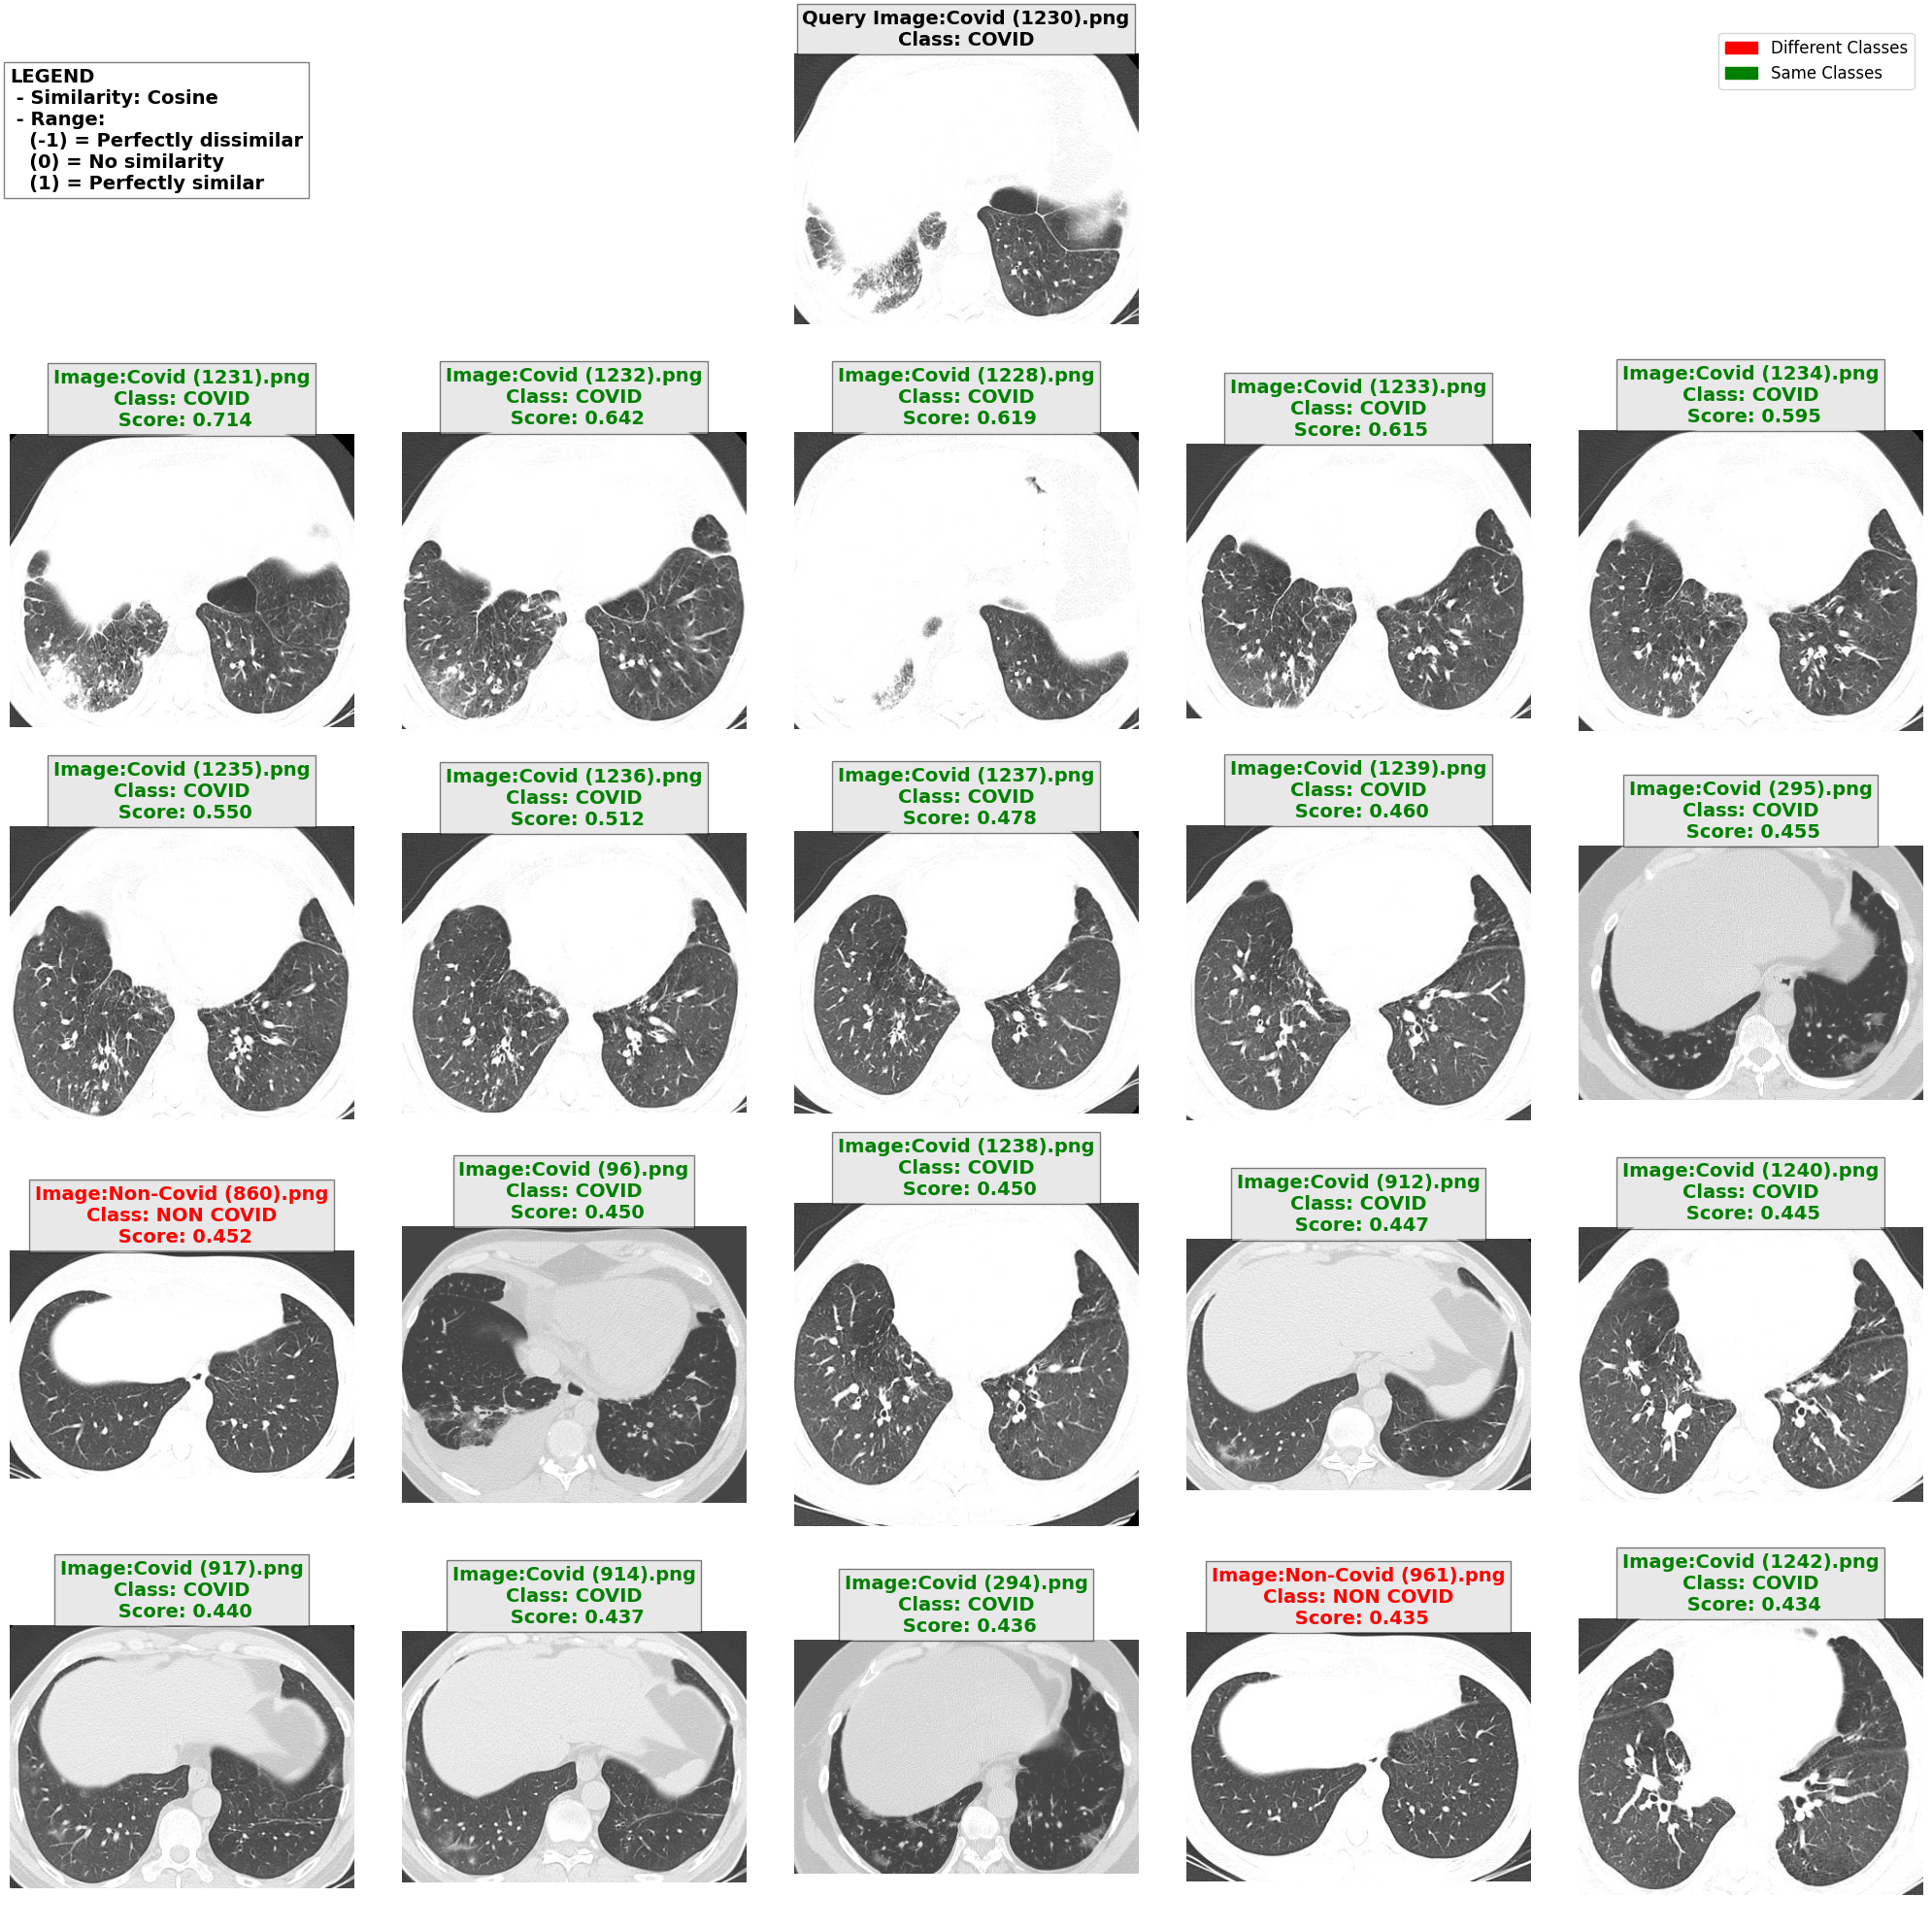

In [37]:
## ************************************ RESNET50 - FROM QUERY FIND SIMILAR - WITH RELEVANCE FEEDBACK ********************************** ##


# Print info. about query
print(f"\n> Query image: {os.path.basename(chosen_file_path)}"
      f"\n> Query label: {chosen_label}")

# Get the features related to the first three image retrieved 
relevant_features, relevant_paths, relevant_labels  = get_relevant_images_features(
    closest_indices_to_query=similar_indices,
    all_features=train_features, 
    training_dataset=train_dataset, 
    query_chosen_label=chosen_label
)
# Print paths and labels of relevant images 
print(f"\n> Relevant images: {relevant_paths} - Labels: {relevant_labels}")

irrelevant_features, irrelevant_paths, irrelevant_labels = get_irrelevant_images_features(
    closest_indices_to_query=similar_indices,
    all_features=train_features, 
    training_dataset=train_dataset, 
    query_chosen_label=chosen_label
)
# Print paths and labels of irrelevant images 
print(f"\n> Irrelevant images: {irrelevant_paths} - Labels: {irrelevant_labels}")


# New features
new_features = relevance_feedback(query_features=chosen_features, 
                                  relevant_features_retrieved=relevant_features, 
                                  irrelevant_features_retrieved=irrelevant_features)

# Find similar images with the new features
relevant_indices, relevant_distances = find_top_n_similar_images(features_of_query=new_features, all_features=train_features)

# Lists of similar image found and corresponding true labels
refined_similar_images = [train_dataset.iloc[index]["file_paths"] for index in relevant_indices]
refined_similar_labels = np.array([train_dataset.iloc[index]["labels"] for index in relevant_indices])

# Given query -> Plot similar images with class labels and info.
plot_similar_images(path_to_query=chosen_file_path, 
                    query_label=chosen_label, 
                    similar_image_paths=refined_similar_images,
                    similar_image_labels=refined_similar_labels, 
                    distance_measures=relevant_distances,
                    is_relevance=True)


In [38]:
## ********************************* MOBILENET - SINGLE CASE PERFORMANCE EVALUATION - WITH RELEVANCE FEEDBACK ******************************* ##


# Find similar images with the new features
relevant_indices, relevant_distances = find_top_n_similar_images(features_of_query=new_features, all_features=train_features)
# Corresponding true labels of the similar images found (TOP_N)
refined_similar_labels = np.array([train_dataset.iloc[index]["labels"] for index in relevant_indices])

# Single case evaluation after Relevance Feedback
relevant_precision, relevant_recall, relevant_f1, relevant_dcg = compute_evaluation_metrics(
    query_img_label=chosen_label, 
    image_labels_retrieved=refined_similar_labels,
    k=20
)

# Print info. about query
print(f"\n> Query image: {os.path.basename(chosen_file_path)}"
      f"\n> Query label: {chosen_label}")

# Print Evaluation scores
print(f"\n> MOBILENET SINGLE CASE PERFORMANCE EVALUATION WITH RELEVANCE FEEDBACK:")
print(f"-- Precision score: {relevant_precision:.3f}")
print(f"-- Recall score: {relevant_recall:.3f}")
print(f"-- F1-score: {relevant_f1:.3f}")
print(f"-- DCG: {relevant_dcg:.3f}")



> Query image: Covid (1230).png
> Query label: 0

> MOBILENET SINGLE CASE PERFORMANCE EVALUATION WITH RELEVANCE FEEDBACK:
-- Precision score: 0.900
-- Recall score: 0.265
-- F1-score: 0.409
-- DCG: 6.530


# Evaluation on the entire set with relevance feedback
 
## Function: `evaluation_after_relevance_feedback`

### Description:
This function performs an evaluation on the test dataset by computing precision, recall, and F1-score for each feature after performing relevance feedback. It iterates through each feature in the test dataset, computes cosine similarity to find similar images, performs relevance feedback, computes precision, recall, and F1-score with the new features, and computes the average precision, recall, and F1-score for the entire test dataset.


In [28]:
# Evaluation performed on all the element of the test set, performing relevance feedback 
def evaluation_after_relevance_feedback(query_dataset: pd.DataFrame, training_dataset: pd.DataFrame, all_retrieved_features) -> tuple[float, float, float, float]:
    """
    Evaluation on the test dataset by computing precision, recall, and F1-score for each feature 
    and output the average of them.

    :param query_dataset: DataFrame containing the test dataset.
    :param training_dataset: DataFrame containing the training dataset.
    :param all_retrieved_features: Retrieved similar features.

    :return: Average precision, recall, and F1-score.
    """
    # Dictionary to collect data
    metrics = {k: {"precision": [], "recall": [], "f1": [], "dcg": []} for k in K_VALUES}
    
    print("\n> Computing evaluation metrics...")
    # Iterate through each feature in the test dataset
    for query_file_path, query_label, query_feature in zip(query_dataset["file_paths"], query_dataset["labels"], query_dataset["features"]):
        # Print query image basename
        print(f"- Processing file: {os.path.basename(query_file_path)}, label: {query_label}")
        
        # Compute cosine distances and find similar images
        old_similar_indices, _ = find_top_n_similar_images(features_of_query=np.array(query_feature), all_features=all_retrieved_features)
        
        # Get the similar images' features
        relevant_similar_features, relevant_similar_paths, relevant_similar_labels = get_relevant_images_features(
            closest_indices_to_query=old_similar_indices, 
            all_features=all_retrieved_features, 
            training_dataset=train_dataset, 
            query_chosen_label=query_label,
        )
        # Print paths and labels of relevant images 
        print(f"-- Relevant images: {relevant_similar_paths} - Labels: {relevant_similar_labels}")
        
        # Get the similar images' features
        irrelevant_similar_features, irrelevant_similar_paths, irrelevant_similar_labels = get_irrelevant_images_features(
            closest_indices_to_query=old_similar_indices, 
            all_features=all_retrieved_features, 
            training_dataset=train_dataset, 
            query_chosen_label=query_label,
        )
        # Print paths and labels of relevant images 
        print(f"-- Irrelevant images: {irrelevant_similar_paths} - Labels: {irrelevant_similar_labels}\n")
        
        # Perform Relevant feedback
        relevance_features = relevance_feedback(
            query_features=query_feature, 
            relevant_features_retrieved=relevant_similar_features, 
            irrelevant_features_retrieved=irrelevant_similar_features
        )
        
        # Find similar images with the new features
        new_similar_indices, new_similar_distance = find_top_n_similar_images(features_of_query=relevance_features, all_features=train_features)

        # Extract labels of similar images
        new_similar_labels = training_dataset.iloc[new_similar_indices]["labels"].to_numpy()

        # Loop through K
        for k in K_VALUES:
            # Compute precision, recall, and F1-score
            precision, recall, f1, dcg = compute_evaluation_metrics(query_img_label=query_label, image_labels_retrieved=new_similar_labels, k=k)
            # Append scores to Dictionary
            metrics[k]["precision"].append(precision)
            metrics[k]["recall"].append(recall)
            metrics[k]["f1"].append(f1)
            metrics[k]["dcg"].append(dcg)
        
    print("> Process completed!")

    # Compute metrics average and build a dataframe
    relevance_avg_metrics = {k: {"avg_precision": np.mean(metrics[k]["precision"]),
                       "avg_recall": np.mean(metrics[k]["recall"]),
                       "avg_f1": np.mean(metrics[k]["f1"]),
                       "avg_dcg": np.mean(metrics[k]["dcg"])}
                   for k in K_VALUES}
    df_relevance_avg_metrics = pd.DataFrame.from_dict(relevance_avg_metrics, orient="index")
    df_relevance_avg_metrics.index.name = "K"
    
    # Save the Dataframe as CSV
    metrics_path = os.path.join(DATA_PATH, f"{mobilenet_model.model_name}_relevance_feedback_evaluation.csv")
    df_relevance_avg_metrics.to_csv(path_or_buf=metrics_path, float_format="%.3f")

    return df_relevance_avg_metrics


In [ ]:
# Perform Evaluation after Relevant Feedback
df_avg_rf_metrics = evaluation_after_relevance_feedback(
    query_dataset=test_dataset, 
    training_dataset=train_dataset, 
    all_retrieved_features=train_features
)


In [30]:
# Print Average Evaluation scores
print(f"\n> MOBILENET AVERAGE PERFORMANCE WITH RELEVANCE FEEDBACK:")
print(df_avg_rf_metrics.to_string())



> MOBILENET AVERAGE PERFORMANCE WITH RELEVANCE FEEDBACK:
     avg_precision  avg_recall    avg_f1    avg_dcg
K                                                  
5         0.999195    0.080326  0.146555   2.946902
10        0.961167    0.150751  0.255235   4.422370
20        0.890845    0.267275  0.401526   6.474973
30        0.843997    0.371587  0.503518   8.067656
40        0.807093    0.467778  0.577992   9.411861
50        0.782334    0.561985  0.638631  10.646641
60        0.762441    0.654685  0.688095  11.786387
70        0.744898    0.744151  0.727654  12.843082
80        0.728647    0.829760  0.758917  13.826154
90        0.714979    0.914983  0.785718  14.767424
100       0.703340    1.000000  0.808804  15.675631
